In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

sns.set(palette="Set2")

# Load dataset

Below we will load in both the training and testing datasets.

In [2]:
test_df = pd.read_csv("test.csv").set_index("Id")
train_df = pd.read_csv("train.csv").set_index("Id")

# Looking at the data

### Target Distribution
Below we will do a bit of EDA (Explanatory Data Analysis), beginning with our Target Variable.

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

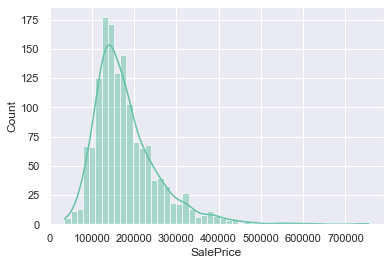

In [3]:
# Lets look at the distribution of our target
sns.histplot(data=train_df["SalePrice"], kde=True)

So its clear that our target variable is not normally distributed. Although we are not running any statistical test on this data, having a normal distribution for our target will be nicer and is required for the submission into the competition. 

To normalize our target variable, we can simply log (as suggested by Kaggle) our house prices. This is also a common method in Econometrics, however, for different reasons (interpretability and testing).

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

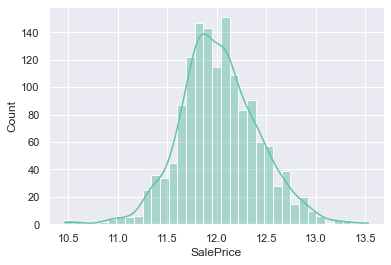

In [4]:
# Log the target
y = np.log(train_df["SalePrice"])
sns.histplot(data=y, kde=True)

Now our target's distribution is looking much better!

Now we can begin looking at the rest of our data, our features. 

### The Features

In [5]:
# Concat test and train data so that we can clean it all at once
df = pd.concat([train_df, test_df]).drop("SalePrice", axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [7]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


So from the quick overviews of our data, we can notice some important characteristics of our features. Namely the "object" type variables such as, MSZoning, something that we will want to encode later on.

Something else that is very obvious is that some of our features seem to have a large number of NaN type values. Missing data can lead to a big issue for our model's performance. Lets take a closer look into which features have the highest number of missing values. 

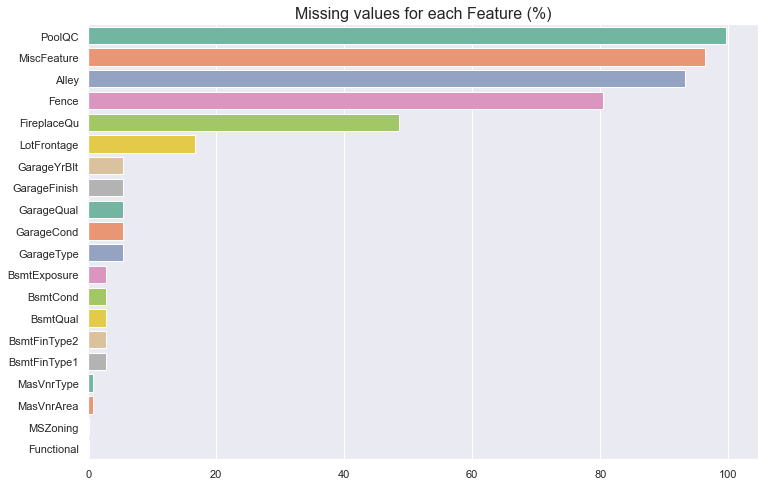

In [8]:
# Create a dataframe that holds the percentage of missing values for each feature, sort descending
df_na = ((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False)

# Plot our findings
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Missing values for each Feature (%)", fontsize=16)
sns.barplot(y=(df_na.head(20).index), x=df_na.head(20).values, palette="Set2")
plt.show()

From the graph and output above, we can see that PoolQC, MiscFeature, Alley, Fence and FireplaceQU have the highest percentage of NaN values. 

Since a high number of missing values, can heavily disrupt the performance of the model, we could either:

1. Drop the rows or columns (features) with missing values
2. Impute the missing values

Although the first option is viable, option two is almost always the better choice. Thus we will impute these missing values latter on.

> **Note:** that SalePrice should be excluded, as it only has high NaNs due to the concatenation of our Test set (which has no SalePrice feature) and our Training set.

Another thing we should look at is correlation in our features. More specifically, we should we wary of something like Multicollinearity.

Lets use Seaborn's Heatmap function to plot out correlations in a nice visual format.

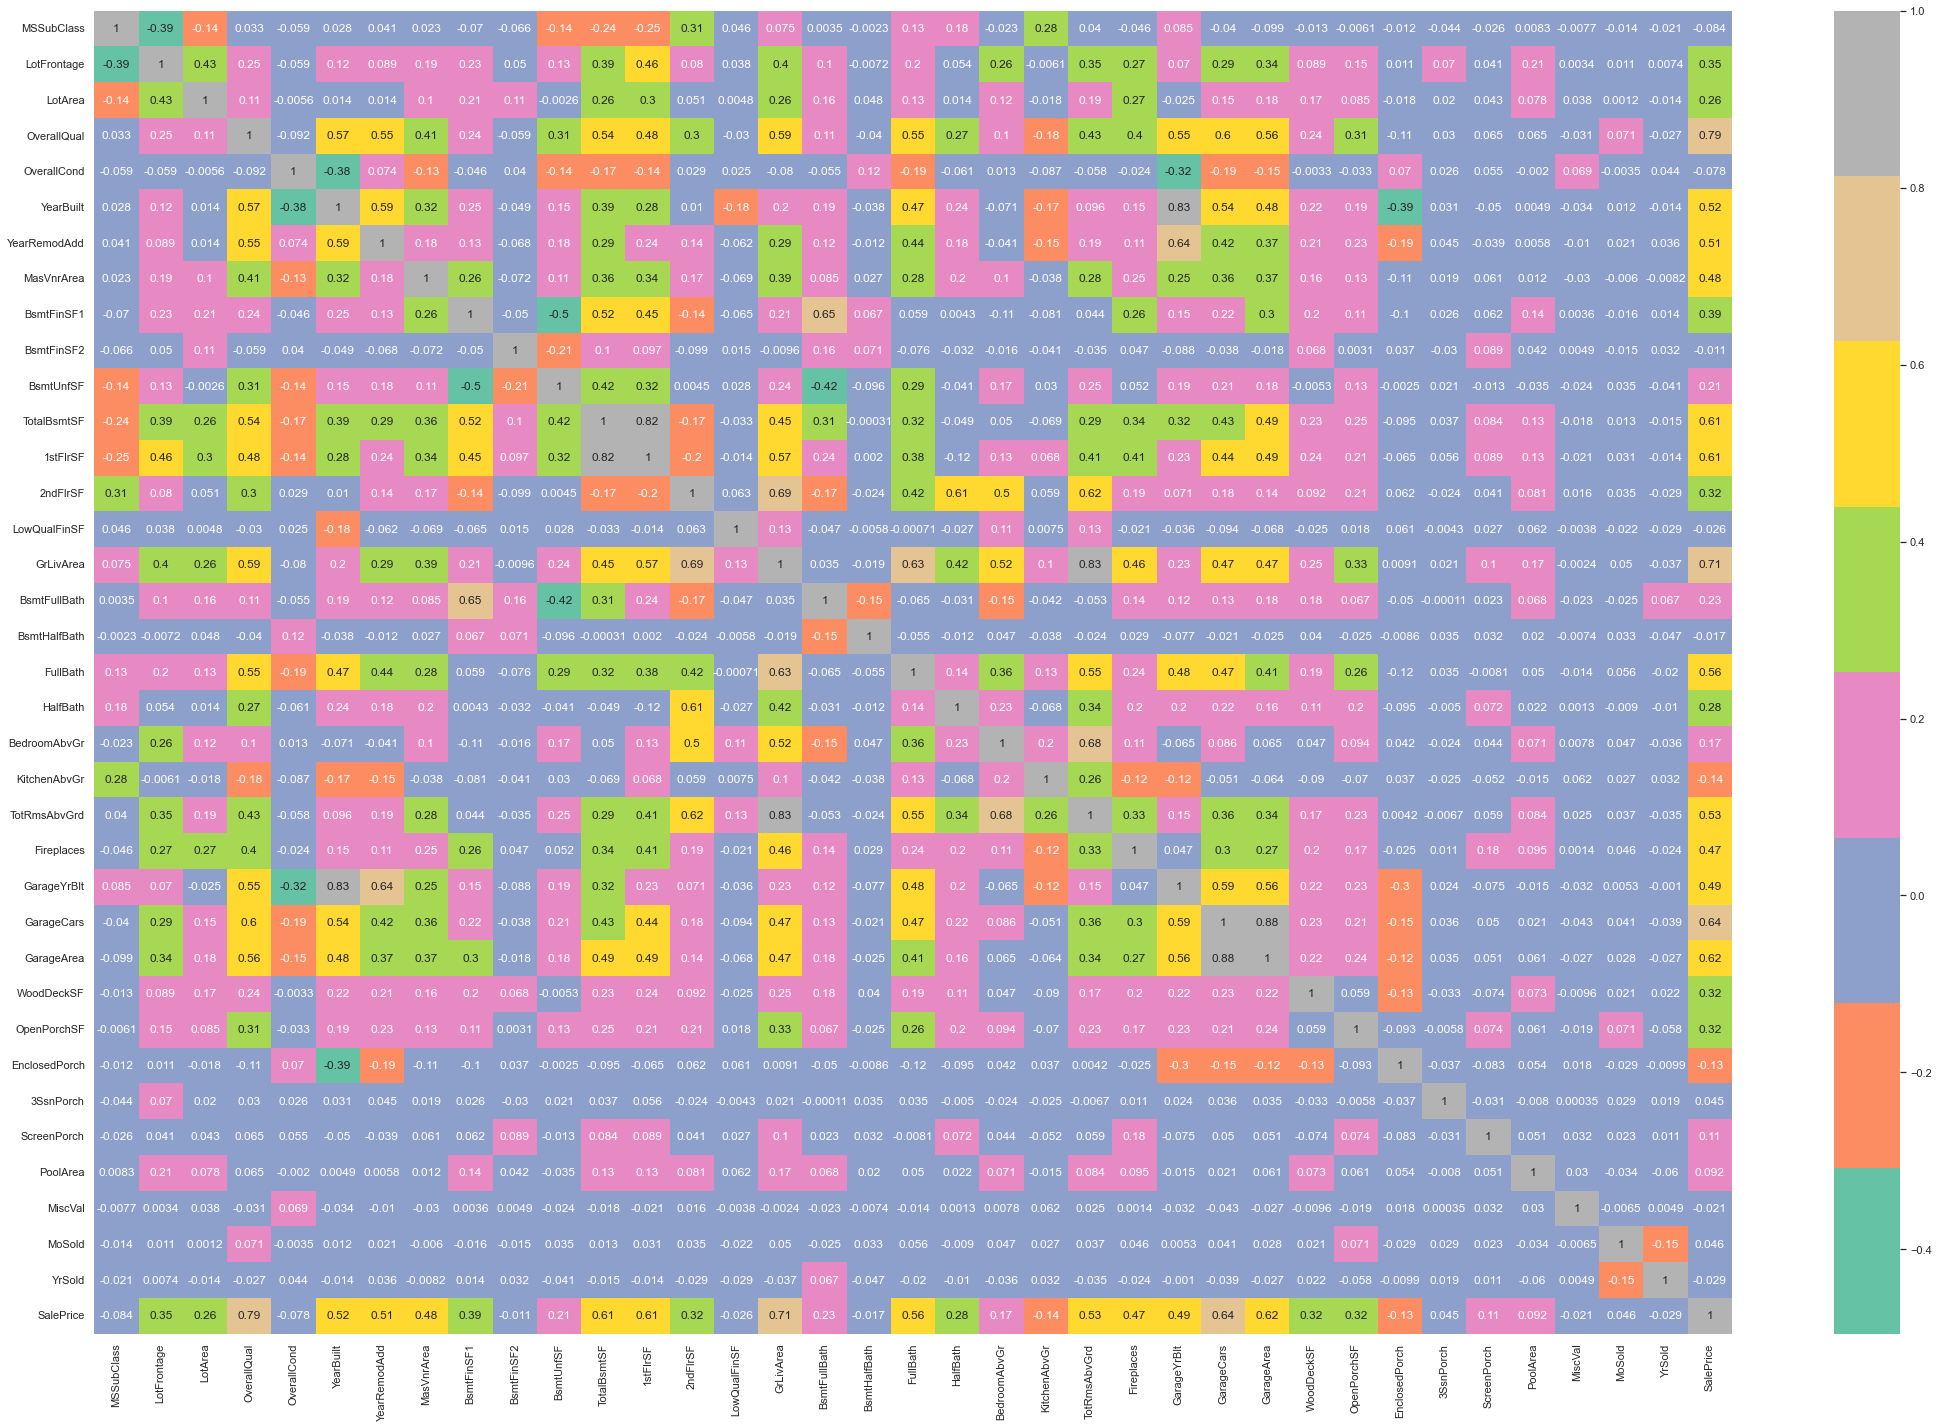

In [9]:
corrmat = train_df.corr()
plt.subplots(figsize=(30, 20))
sns.heatmap(corrmat, annot=True, cmap="Set2")
plt.tight_layout()
plt.show()

### Feature Dtypes

Next, as mentioned above, we should sort out variables that categorical (with an object dtype). We should also note categorical variables that do not have a object dtype, like OverallQual. For categorical variables like OverallQual, ordinal encoding (rather than one-hot encoding) would work best.

> **Note**: Since we focus on using the XGBoost Regression model in this notebook, one-hot encoding does not actually do much to enhance the performance of the model relative to ordinal encoding, which is much cheaper in terms of dimensionality. This is due to the nature of decision tree based regression models. Although one-hot encoding is an option, and a good option for certian models, like a linear models, it does not really benefit us and thus it will not be used.

Ordinal encoding in this case makes sense (ie: theres inherent order in the data) and it also limits our need to create a list of new features leading to issues with high dimensionality ("The curse of dimensionality").

In [10]:
# Lets create lists to seperate our Numeric features and Categorical features
# Some of the numeric (int dtype) features are Categorical so lets not put include them into our list of numeric features
num_cols = [col for col in df.columns if df[col].dtypes in [float, int] and col not in ["MSSubClass", "OverallQual", "OverallCond", 
                                                                                        "YrSold", "MoSold", "YearRemodAdd", "SalePrice"]]

obj_cols = [col for col in df.columns if df[col].dtypes == "object"] # List of object type features

# We know that MSSubClass, OverallQual, and OverallCond are Categorical variables but they are held as int types
# Lets add them to a new list that holds categorical columns and turn them into category type features
cat_cols = ["MSSubClass", "OverallQual", "OverallCond", "YrSold", "MoSold", "YearRemodAdd"] + obj_cols

# The list above holds all categorical features
# But lets make a subset of categorical features that will be used for ordinal encoding (rather than one-hot)
ord_cols = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
           'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
           'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MSSubClass', 'Functional', 
            "YrSold", "MoSold", "YearRemodAdd", "Alley", "LotShape", "LandSlope", 
            "Utilities", "CentralAir", "Electrical"]

# The remaining categoricals (nominal) will be one-hot encoded
## NOTE: DID NOT END UP DOING ANY ONE-HOT ENCODING, MAKES NO DIFFERENCE FOR TREE BASED MODELS ##
nominal_cols = [col for col in df.columns if df[col].dtypes == "object" and col not in ord_cols]

In the case of Ordinal features, lets take a look at them:

* The features Order
* Correlation to our Target

/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


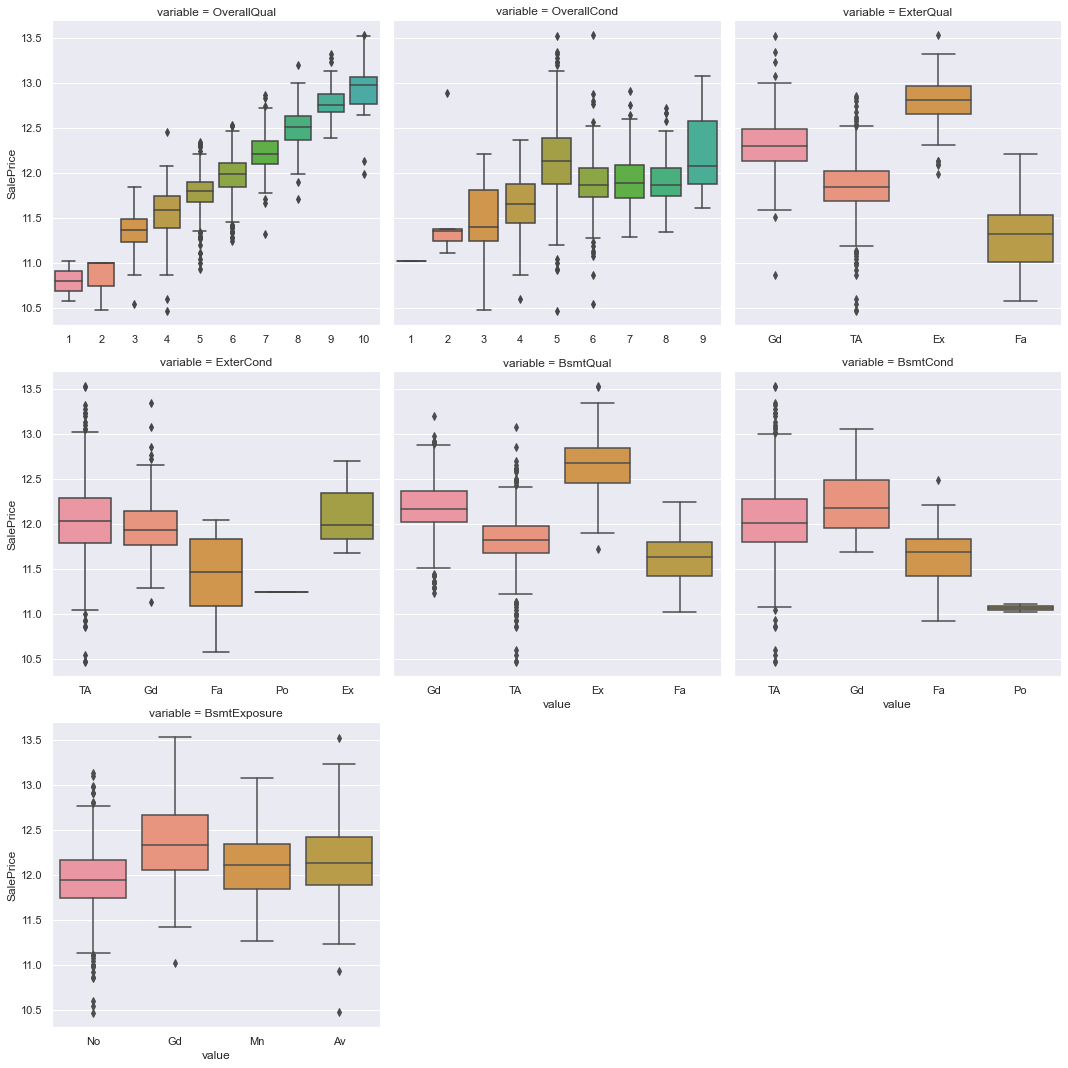

In [11]:
# We can use boxplots to look at the relation between some of the categorical features and the target
def box_plots(df, features):
    df["SalePrice"] = np.log(df["SalePrice"])
    sns.catplot(x="value", y="SalePrice", col="variable", 
                data=train_df.melt(id_vars="SalePrice", value_vars=features), kind="box", sharex=False, height=5, aspect=1, col_wrap=3)
    plt.tight_layout()
    
box_plots(train_df, ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure'])

We can see that many of the ordinal features are not actually set in their particular orders that they should be.

This should be changed.

In [12]:
# This code was taken from "Feature Engineering for House Prices", on Kaggle,
# it lists out the ordinal order and standardizing the ordering names
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"]
}

# Pre-Processing the data

## Establishing a preliminary dataset

In [13]:
def process_data(train, test, drop_y=True):
    # Put the training and test set together, so that we can transform the data in one go
    df = pd.concat([train, test])
    if drop_y == True:
        df = df.drop("SalePrice", axis=1)
    
    ## imputing before encoding here ##
    imputed = impute(df)
    encoded = encode(imputed)
    final_df = set_types(encoded)

    # Split the data back into training and test sets
    train_df = final_df.loc[train.index, :]
    test_df = final_df.loc[test.index, :]
    return train_df, test_df

In [14]:
from pandas.api.types import CategoricalDtype

def categorize(df, cols=cat_cols):
    return pd.concat([df[num_cols], df[cols].astype("category")], axis=1)

def impute(df):
    # This returns a completed dataframe
    imputer = SimpleImputer(strategy="most_frequent")
    imp_df = pd.DataFrame(imputer.fit_transform(df))
    imp_df.index = df.index
    imp_df.columns = df.columns
    return imp_df

def encode(df, make_dummys=False, ordered_levels=ordered_levels, ord_cols=ord_cols, nom_cols=nominal_cols):
    """
    Here I use pd.factorize and LabelEncoder to encode the data,
    both do the exact same, they are just implemented slightly differently.
    One being a sklearn function and the other being a pandas function.
    
    I also have some code snippets to generate dummy variables, however,
    dummy variables and ordinal variables are treated the same in Tree models, and since 
    ordinal variables is cleaning and easier to look at, we will no create any dummy variables. 
    (Not here anyways)
    
    """
    # Encoding ordinal variables that DO need to be ordered
    df = df.copy()
    for key, vals in ordered_levels.items():
        df[key] = df[key].astype(CategoricalDtype(categories=vals, ordered=True))
        # Order the ordinal values after encoding
        codes, uniques = pd.factorize(df[key], sort=True)
        df[key] = codes
        
    """
    Ordered_levels and ord_cols share the same columns.
    Need to isolate the columns in ord_cols that are NOT in the ordered_levels.
    
    """
    ord_cols = [col for col in cat_cols if col not in ordered_levels] ## CHANGED "ord_cols" to "cat_cols"
    # Encoding ordinal variables that DO NOT need to be ordered
    lncode = LabelEncoder()
    ord_df = pd.DataFrame()
    for col in ord_cols:
        lncode.fit(list(df[col].values))
        ord_df[col] = lncode.transform(list(df[col].values))
    ord_df.index = df.index
    
    # Putting the final DataFrame together
    df = df.drop((nom_cols + ord_cols), axis=1) # drop the unencoded features
    df = df.join([ord_df])
    return df

# Create a function to finalize the Dtypes for each feature
def set_types(df):
    # keep ordinal features as int types
    df[ord_cols] = df[ord_cols].astype(int)
    df[num_cols] = df[num_cols].astype(float)
    cols = [col for col in df.columns if col not in ord_cols and col not in num_cols]
    df[cols] = df[cols].astype(int)
    df["YearBuilt"] = df["YearBuilt"].astype(int)
    return df

In [15]:
train, test = process_data(train_df, test_df)
X = train.copy()
X_test = test.copy()

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1460 non-null   float64
 1   LotArea        1460 non-null   float64
 2   LotShape       1460 non-null   int64  
 3   Utilities      1460 non-null   int64  
 4   LandSlope      1460 non-null   int64  
 5   OverallQual    1460 non-null   int64  
 6   OverallCond    1460 non-null   int64  
 7   YearBuilt      1460 non-null   int64  
 8   MasVnrArea     1460 non-null   float64
 9   ExterQual      1460 non-null   int64  
 10  ExterCond      1460 non-null   int64  
 11  BsmtQual       1460 non-null   int64  
 12  BsmtCond       1460 non-null   int64  
 13  BsmtExposure   1460 non-null   int64  
 14  BsmtFinType1   1460 non-null   int64  
 15  BsmtFinSF1     1460 non-null   float64
 16  BsmtFinType2   1460 non-null   int64  
 17  BsmtFinSF2     1460 non-null   float64
 18  BsmtUnfS

In [17]:
X.head()

,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,...,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,GarageType,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450.0,0,1,2,6,4,2003,196.0,2,...,1,12,13,1,2,1,1,2,8,4
2,80.0,9600.0,0,1,2,5,7,1976,0.0,1,...,1,8,8,2,1,1,1,2,8,4
3,68.0,11250.0,1,1,2,6,4,2001,162.0,2,...,1,12,13,1,2,1,1,2,8,4
4,60.0,9550.0,1,1,2,6,4,1915,0.0,1,...,1,13,15,2,0,1,5,2,8,0
5,84.0,14260.0,1,1,2,7,4,2000,350.0,2,...,1,12,13,1,2,1,1,2,8,4


In [18]:
# Check for any missing values left
print(f"Number of missing values: {X.isnull().any().sum()}")

Number of missing values: 0


In [19]:
def score_model(X, y, model=XGBRegressor(random_state=1, objective="reg:squarederror")):
    score = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

### Baseline Score

In [20]:
%%time
# Baseline score before any feature engineering
print(f"Given a naive baseline XGBoost model, we get a RMSE: {score_model(X, y)}\n\n")

Given a naive baseline XGBoost model, we get a RMSE: 0.13156585821950753


CPU times: user 27.5 ms, sys: 99.9 ms, total: 127 ms
Wall time: 1.72 s


# Some feature engineering

We have seen our performance of the XGBRegressor without any hyper-parameter tuning and minimal feature engineering.

Lets begin improving the model's performance by improving our dataset.

### Checking correlation with target

Features that correlate highly with the target will have a stronger impact on the target.

In [21]:
corr_w_targ = X.corrwith(y).sort_values(ascending=False)
corr_w_targ.head()

GrLivArea      0.700927
GarageCars     0.680625
ExterQual      0.678840
KitchenQual    0.667893
BsmtQual       0.657131
dtype: float64

In [22]:
high_corr = corr_w_targ.head(12).index
high_corr

Index(['GrLivArea', 'GarageCars', 'ExterQual', 'KitchenQual', 'BsmtQual',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt',
       'OverallQual', 'GarageFinish'],
      dtype='object')

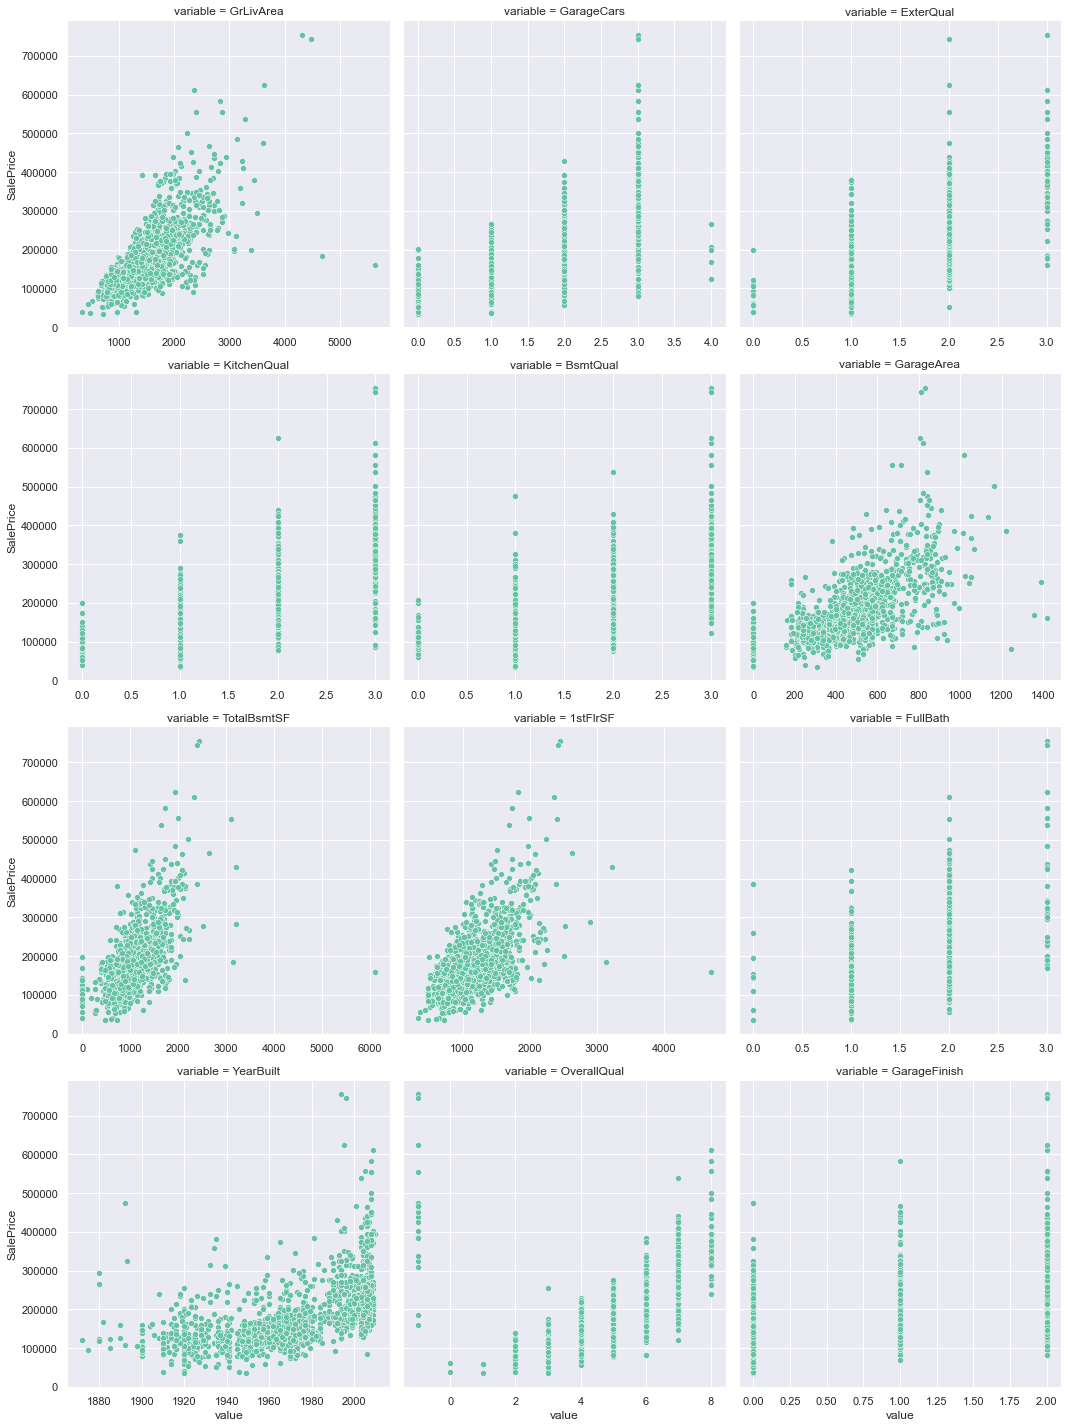

In [23]:
def plot_corrs(df, y=y, cols=high_corr, n_cols=3):
    df = df.join(y)
    df = pd.melt(df, id_vars="SalePrice", value_vars=cols)
    sns.relplot(x=df["value"], y=np.exp(df["SalePrice"]), col=df["variable"], col_wrap=n_cols, facet_kws={"sharex": False})

plot_corrs(X)

From our correlation analysis we see that GrLivArea, GarageCars, ExterQual, KitchenQual and BsmtQual are the features most correlated with our target. Inuitively, GrLivArea, ExterQual, KitchenQual and BsmtQual make sense as being highly correlated with our target. For example a bigger house or a house with a higher level of quality is likely going to be more expesnive.

One of the variables that is somewhat less intuitive is the GarageCars features. In contrast there is a also a variable called GarageArea, which is plotted above. Although GarageArea would be the more intuitive pick for target correlation, we can see that GarageCars (number of cars able to fit inside the garage) has a stronger correlation and is therefore, going to give more "power" in our model.

This is a good example of why this correlation analysis is useful, because we are using a "data driven" approach to find features that will give us the most information, which is not always as obvious as it would seem.

## Aggreate some features

Another thing we can do to help with the performance of our model, is to create new features, which encapsulate information from our other features. In this case we will be aggregating features to create one single feature. Doing this can "simplify" our model, without losing information, and therefore, improve the model's performance.

In [24]:
# Lets aggreate some features together
X["TotalSF"] = X["1stFlrSF"] + X["2ndFlrSF"] + X["TotalBsmtSF"]
X["OutDoorSF"] = X["WoodDeckSF"] + X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"] + X["PoolArea"]

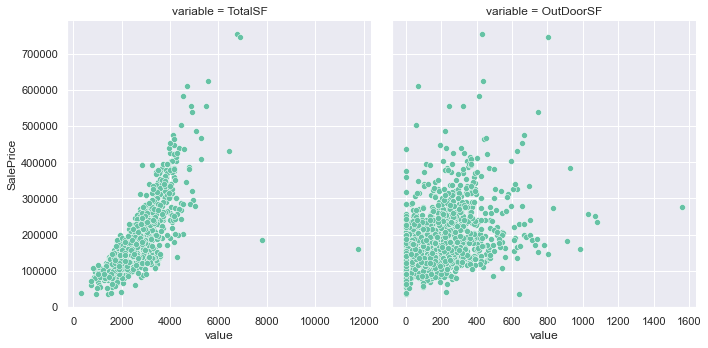

In [25]:
plot_corrs(X, cols=["TotalSF", "OutDoorSF"], n_cols=2)

## Mutual Information

Another useful feature engineering task we can deploy is Mutal Information. Mutual information differs from correlation in that it uses the amount of information one random variable gives about another as its metric. 

More specifically, MI uses the idea of *surpise*, which is the amount of information or *surprise* one variable gives about another.

> In information theory, *surprise* is surprise that of an event happening given some piece of information (from a variable). More concretely, surprise is the *inverse of probability*. For example, an event with a high probability of happening has a low surprise, and an even with a low probability of happening has a high level of surprise. Surpise can then be said to be the level of information given by a random variable drawn from a sample. Why? Because if you were to sequentially draw a variable (some information) from a sample (our dataset) and you kept getting information that told you the same thing (high probability, low surprise) than you probably would say that you're not getting much from continuosly drawing. But if everytime you drew from the sample (dataset), the information (from a variable) was different, then you'd probably say that you are gaining a lot of information from drawing. Thus, MI builds on this idea, in that a varaible with high surprise about another gives a lot of information about the other variable and obtains a high MI score.

In [26]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    # Create list of discrete features for MI scoring
    # mutual_info_regression takes in a bool array, not an array of column names
    discrete_features = (X.dtypes == int)
    # Make MI scores
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [27]:
mi_scores = make_mi_scores(X, y)
mi_scores.head(10)

TotalSF         0.685628
OverallQual     0.568199
Neighborhood    0.525899
GrLivArea       0.457698
YearBuilt       0.405270
GarageCars      0.375222
TotalBsmtSF     0.361012
GarageArea      0.360741
ExterQual       0.335341
KitchenQual     0.331611
Name: MI Scores, dtype: float64

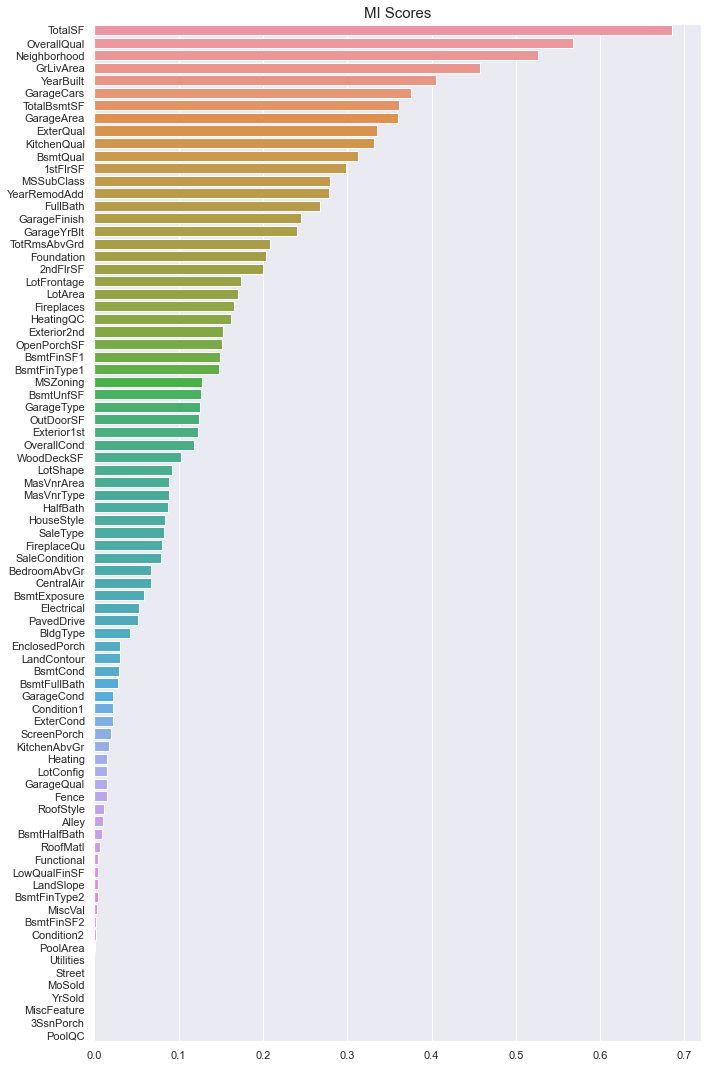

In [28]:
def plot_mi_scores(scores):
    scores = scores
    fig, ax = plt.subplots(figsize=(10, 15))
    sns.barplot(x=scores.values, y=scores.index)
    plt.title("MI Scores", fontsize=15)
    plt.tight_layout()
    
plot_mi_scores(mi_scores)

We can see that some of our features that obtained a high MI score are the same features that correlate highly with the target, in addition to some new features, including our newly aggregate feature, *TotalSF* (total surface area of the lot).

In [29]:
bottom_mi = mi_scores[49:]
print(round(bottom_mi, 4))

EnclosedPorch    0.0309
LandContour      0.0306
BsmtCond         0.0287
BsmtFullBath     0.0286
GarageCond       0.0224
Condition1       0.0218
ExterCond        0.0218
ScreenPorch      0.0193
KitchenAbvGr     0.0178
Heating          0.0155
LotConfig        0.0153
GarageQual       0.0152
Fence            0.0151
RoofStyle        0.0113
Alley            0.0100
BsmtHalfBath     0.0089
RoofMatl         0.0066
Functional       0.0047
LowQualFinSF     0.0047
LandSlope        0.0043
BsmtFinType2     0.0039
MiscVal          0.0036
BsmtFinSF2       0.0024
Condition2       0.0016
PoolArea         0.0008
Utilities        0.0000
Street           0.0000
MoSold           0.0000
YrSold           0.0000
MiscFeature      0.0000
3SsnPorch        0.0000
PoolQC           0.0000
Name: MI Scores, dtype: float64


In [30]:
# Lets get rid of features with low MI scores.
def drop_low_mi(X):
    cols = [idx for idx in mi_scores.index if mi_scores[idx] <= 0.0]
    return X.drop(cols, axis=1)

# Feature Creation

Feature creation will include:

* Regular feature creation (mathematical, aggregation, counts)
* Clustering with K-means
* PCA
* Target Encoding

### Regular feature creation

In [31]:
# These will be regular math transformations, aggregating and dividing features to make new features
def math_transformations(X):
    df = pd.DataFrame()
    df["TotalSF"] = X["1stFlrSF"] + X["2ndFlrSF"] + X["TotalBsmtSF"]
    df["OutDoorSF"] = X["WoodDeckSF"] + X["OpenPorchSF"] + X["EnclosedPorch"] + X["ScreenPorch"]
    df["LivLotRatio"] = X["GrLivArea"] / X["LotArea"]
    return df

# Interactions are features that are multiplied with a dummy variable
# this acts as sort of a "on" or "off" switch for the model
def interactions(X):
    bldgtype = pd.get_dummies(X["BldgType"], prefix="Bldg")
    bldgtype = bldgtype.multiply(X["TotalSF"], axis=0)
    
    contour = pd.get_dummies(X["LandContour"], prefix="LandContour")
    contour = contour.multiply(X["TotalSF"], axis=0)
    
    overallqual = pd.get_dummies(X["OverallQual"], prefix="OverallQual")
    overallqual = overallqual.multiply(X["TotalSF"], axis=0)
    
    neighborhood = pd.get_dummies(X["Neighborhood"], prefix="Neighborhood")
    neighborhood = neighborhood.multiply(X["TotalSF"], axis=0)
    
    kitchens = pd.get_dummies(X["KitchenQual"], prefix="KitchenQual")
    kitchens = kitchens.multiply(X["KitchenAbvGr"], axis=0)
    
    return bldgtype.join([contour, overallqual, neighborhood, kitchens])

# This counts the number of outside features for each house
def counts(X):
    df = pd.DataFrame()
    df["PorchTypes"] = X[["ScreenPorch",
                         "WoodDeckSF", "OpenPorchSF",
                         "EnclosedPorch"]].gt(0.0).sum(axis=1)
    return df

# This is creating a feature that records the average size of houses in each neighbourhood
# This feature would help distinguish houses in neighbourhoods with large house (and likely more expensive houses)
# from houses in neighbourhoods with smaller houses (less expensive houses)
def group_transforms(X):
    df = pd.DataFrame()
    df["MedNhbdArea"] = X.groupby("Neighborhood")["GrLivArea"].transform("median")
    return df

### K-means clustering

K-means clustering is a form of unsupervised machine learning, in that the k-means algorithm will be able to cluster unlabled data on it own, forming "made up" groups within our dataset.

This can act as another feature, in our final dataset, as it will hopefully be able to cluster together houses with similar characteristics and thus prices, adding another peice of information that will help our model's performance.

K-mean clustering uses a distance (euclidean) based metric for data point "likeness", thus it is crucial that we scale our data before clustering by k-means.

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "GrLivArea",
    "TotalSF"
]

def kmeans_cluster(X, features, n_clusters=20):
    scaler = StandardScaler()
    df = X.copy()
    
    # Standardize data, as it affects clustering
    df_selected = X.loc[:, features]
    df_scaled = pd.DataFrame(scaler.fit_transform(df_selected))
    df_scaled.index = df_selected.index
    df_scaled.columns = df_selected.columns
    
    # Cluster the data, and put it into an empty dataframe
    # This empty dataframe will be concated to the final dataframe in our "create_features" function below
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=1)
    output_df = pd.DataFrame()
    output_df["Cluster"] = kmeans.fit_predict(df_scaled)
    return output_df

### PCA 

PCA is a form of dimension reduction, in essence it will try to find a vector that contains the highest amount of variance, or information, about the data. 

For example if we had 2D data, PCA would find a vector that captures the greatest amount of variance in our dataset and return a 1D data array. Therefore, PCA is good at reducing the dimensions, or features, in our dataset. 

Like with k-means, variance is highly sensitive to scale (ie: Big numbers will have higher variance than small numbers), thus it is crucial to scale before applying PCA as well.

In [33]:
from sklearn.decomposition import PCA

def apply_pca(X):
    # In apply PCA, scaling is critical, to give each data point unit variance.
    # In other words, give each data point equal weight in determaning the PCA.
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(X))
    df_scaled.index = X.index
    df_scaled.columns = X.columns
    
    # After scaling apply the PCA function
    pca = PCA()
    df_pca = pca.fit_transform(df_scaled)
     # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(df_pca.shape[1])]
    df_pca = pd.DataFrame(df_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, df_pca, loadings

def pca_components(X, features):
    df = X.loc[:, features]
    _, df_pca, _ = apply_pca(df)
    df_pca.index = X.index
    return df_pca

pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

### Target encoding

Below we do some target encoding, which is pretty much a form of encoding were data from the target variable is used. 

The class below is made to automate the process of target encoding, ensure issues such as "leakage" do not become present. 

**NOTE:** This code chunk below was developed and shared by a user on Kaggle.

In [34]:
from category_encoders import MEstimateEncoder
from category_encoders import CatBoostEncoder

In [35]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

# Putting it together

### Making the final feature set

So here we create a function that will put all of our feature engineering functions together and run it. This will then return our final dataset used for modelling.

In [36]:
def create_features(train_df, test_df=None, y=y):
    X = train_df.copy()
    y = y
    mi_scores = make_mi_scores(X, y)
    
    # Check whether the test data frame is passed
    # if so, manipulate the data together, and re-split at the end
    if test_df is not None:
        X_test = test_df.copy()
        X = pd.concat([X, X_test])
        
    # Drop low MI scored features
    X = drop_low_mi(X)
    
    # Transformations
    X = X.join(math_transformations(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    X = X.join(group_transforms(X))
    
    # K-Means Clustering
    X = X.join(kmeans_cluster(X, features=cluster_features))
    
    # PCA
    X = X.join(pca_components(X, pca_features))
    
    # Impute at the very end to get rid of NaN cluster issue...
    X = impute(X)
    
    # Re-split the data
    if test_df is not None:
        X_test = X.loc[test_df.index, :]
        X.drop(df_test.index, inplace=True)
    
    # Target Encoding
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    # encoder = CrossFoldEncoder(CatBoostEncoder, a=1) # Cat boost version of target encoding
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass", "Neighborhood"]))
    if test_df is not None:
        X_test = X_test.join(encoder.transform(X_test))
    
    # Final return, the output
    if test_df is not None:
        return X, X_test
    else:
        return X

In [37]:
# Pre-process the data, impute and encode features
df_train, df_test = process_data(train_df, test_df)

# Feature engineer, add features, cluster, pca, etc...
train_data = create_features(df_train)

train_data.head()

,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,...,KitchenQual_3,PorchTypes,MedNhbdArea,Cluster,PC1,PC2,PC3,PC4,MSSubClass_encoded,Neighborhood_encoded
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450.0,0.0,1.0,2.0,6.0,4.0,2003.0,196.0,2.0,...,0.0,1.0,1500.0,9.0,0.509620,-0.781244,-0.552725,-0.260394,12.333986,12.161778
2,80.0,9600.0,0.0,1.0,2.0,5.0,7.0,1976.0,0.0,1.0,...,0.0,1.0,1437.0,3.0,-0.217811,0.365673,0.669543,0.095846,12.050870,12.315433
3,68.0,11250.0,1.0,1.0,2.0,6.0,4.0,2001.0,162.0,2.0,...,0.0,1.0,1500.0,3.0,0.791333,-0.627040,-0.522370,-0.399394,12.333986,12.161778
4,60.0,9550.0,1.0,1.0,2.0,6.0,4.0,1915.0,0.0,1.0,...,0.0,2.0,1717.0,10.0,-0.032307,0.585773,-0.543582,-1.060262,11.975712,12.183397
5,84.0,14260.0,1.0,1.0,2.0,7.0,4.0,2000.0,350.0,2.0,...,0.0,2.0,2418.0,15.0,1.996811,-0.053033,-0.616808,-0.883284,12.333986,12.669670


In [38]:
# Score of model without any hyperparameter tuning
print(f"After feature engineering, but no hyperparameter tuning, we can get a RSME of: {score_model(train_data, y)}")

After feature engineering, but no hyperparameter tuning, we can get a RSME of: 0.12937905519447915


# Making the Models and Hyperparameter Tuning

The objective here will be to not only hypertune the XGBoost model, which we've used above, but to also add in a LightGBM regression (Microsoft's XGBoost competitor), a SVR (Support Vector Regression), an Elastic Net model, a K-Nearest Neighbours model, and a Lasso Regression. 

To capture the utility of all the models, we will take full advantage of "Stacking Generalization". The basics of stacking is to leverage the power of mutliple models in creating a single set of predictions. More specifically, stacking trains and tests using cross-validation with *base models*, the predictions made from the *base models* are then passed on as new features for the *meta model*. The *meta model* is the "final" model, in that it uses the predictions from the base models a dataset for its training and testing.

In our case specifically, our base models will be: 

* XGBoost
* LightGBM
* SVR (Support Vector Regression)
* Elastic Net model
* K-Nearest Neighbours model

And our meta model (final model):

* Lasso Regression

In practice, we will train all 6 models, adjust the hyper-parameters and then use Sklearn's *StackingRegressor* function to perform the cross-validation for base and meta models.

### XGBoost
Now we will begin to hypertune our XGBoost model.

In [39]:
def hypertune_cv(model, params, X, y):
    
    """
    Here we use RandomizedSearchCV, which is a much faster version of GridSearchCV. 
    However, becase not every possible combination is found using this method, we will 
    run the random search 4 times, returning the the parameters, RMSE, and Accuracy from each
    of the 4 seperate runs.
    
    After finishing, the mean of the parameters from the 4 runs will be used to tune the next model. 
    Repeat until the best performance is achieved.
    
    The mean RSME and Accuracy will also be used to gauge performance.
    """
    
    # Split the data in to training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=1)
    
    # Create empty lists to store output values
    save_params = [] # list to store the parameters used
    rmses = [] # list to store RMSE values
    accs = [] # list to store accuracy values
    
    # Iterate through the parameters 4 times
    i = 0
    while i < 4:
        # Using Sklearn's RandomizedSearchCV
        rs = RandomizedSearchCV(estimator=model, param_distributions=params, scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=1)
        # Fitting the new instance (of the RandomizedSearchCV; treated like an instance of a regression model)
        rs.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=0)
        # Adding values to lists
        save_params.append(rs.best_params_)
        best_score = rs.best_score_
        rmses.append(np.sqrt(-best_score))
        accs.append(accuracy_score((y_valid).astype(int), rs.predict(X_valid).astype(int)))
        
        # Print to notify the end of iteration i, repeat until i=4...
        print(f"\n============================END OF ITERATION {i+1}============================\n")
        i += 1
    
    print("\n============================FINISHED============================\n")
    
    # Put the scores and parameters in a dataframe
    scores_df = pd.DataFrame([rmses, accs]).T
    scores_df.columns = ["RMSE", "Accuracy"]
    params_df = pd.DataFrame(save_params, index=np.arange(0, len(save_params)))
    output_df = pd.concat([scores_df, params_df], axis=1)
    
    return output_df

In [40]:
%%time
xgb_params = {
    'learning_rate': np.linspace(0.016, 0.024, 12),
    'max_depth': np.arange(15, 17, 1),
    'subsample': np.linspace(0.42, 0.58, 10),
    'colsample_bytree': np.linspace(0.34, 0.4, 12),
    'n_estimators': np.arange(4290, 5360, 10),
    'min_child_weight': np.linspace(3.2, 4, 20),
    'gamma': np.linspace(0.0058, 0.006, 12),
    'reg_alpha': np.linspace(0.12, 0.196, 10),
    'reg_lambda': np.linspace(1.56, 1.64, 10)
}

xgb_model = XGBRegressor(objective="reg:squarederror", random_state=1)
xgb_param_output = hypertune_cv(xgb_model, xgb_params, train_data, y)
# xgb_param_output = hypertune_cv(xgb_model, xgb_params, scaled_train_final, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

============================END OF ITERATION 1============================

Fitting 5 folds for each of 10 candidates, totalling 50 fits

============================END OF ITERATION 2============================

Fitting 5 folds for each of 10 candidates, totalling 50 fits

============================END OF ITERATION 3============================

Fitting 5 folds for each of 10 candidates, totalling 50 fits

============================END OF ITERATION 4============================


============================FINISHED============================

CPU times: user 8min 1s, sys: 546 ms, total: 8min 2s
Wall time: 8min 2s


In [41]:
# The output table presented shows the mean values and the standard deviation
# The standard deviations from the mean will be used to help tune the next model.
# ie: the range for the tuning in the next model will be, range(mean - std, mean + std)

# Repeat until best performance is achieved
xgb_param_output.describe().iloc[1:3, :]

,RMSE,Accuracy,subsample,reg_lambda,reg_alpha,n_estimators,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree
mean,0.120229,0.90411,0.437778,1.577778,0.179111,4740.0,3.705263,16.0,0.017455,0.005909,0.372727
std,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000


In [42]:
xgb_best_params = {"subsample": 0.437778, "reg_lambda": 1.577778,
                   "reg_alpha": 0.179111, "n_estimators": 4740,
                   "min_child_weight": 3.705263, "max_depth": 16,
                   "learning_rate": 0.017455, "gamma": 0.005909,
                   "colsample_bytree": 0.372727}

score_model(train_data, y, XGBRegressor(**xgb_best_params, objective="reg:squarederror", random_state=1))

0.11880279322570682

We see that are performance (RMSE) reduces significantly after hypertuning. 

Moving on, we will train and hypertune a LightGBM regressor.

### LightGBM

In [43]:
from lightgbm import LGBMRegressor

In [44]:
%%time
lgbm_params = {
    'num_leaves': np.arange(5, 15, 1),
    'learning_rate': np.linspace(0.01, 0.03, 100),
    'max_depth': np.arange(5, 25, 1),
    'subsample': np.linspace(0.05, 0.12, 100),
    'colsample_bytree': np.linspace(0.1, 0.3, 100),
    'n_estimators': np.arange(500, 600, 5),
    'min_split_gain': np.linspace(0, 0.01, 100),
    'reg_lambda': np.linspace(0.1, 0.14, 100),
    'reg_alpha': np.linspace(0.01, 0.1, 100),
    'subsample_for_bin': np.arange(5000, 20000, 1000)
}

lgbm = LGBMRegressor(random_state=1)

lgbm_param_output = hypertune_cv(lgbm, lgbm_params, train_data, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

============================END OF ITERATION 1============================

Fitting 5 folds for each of 10 candidates, totalling 50 fits

============================END OF ITERATION 2============================

Fitting 5 folds for each of 10 candidates, totalling 50 fits

============================END OF ITERATION 3============================

Fitting 5 folds for each of 10 candidates, totalling 50 fits

============================END OF ITERATION 4============================


============================FINISHED============================

CPU times: user 24min 10s, sys: 5min 18s, total: 29min 29s
Wall time: 19min 36s


In [45]:
lgbm_param_output.describe().iloc[1:3, :]

,RMSE,Accuracy,subsample_for_bin,subsample,reg_lambda,reg_alpha,num_leaves,n_estimators,min_split_gain,max_depth,learning_rate,colsample_bytree
mean,0.120414,0.917808,18000.0,0.112929,0.120606,0.090909,14.0,560.0,0.000101,19.0,0.018081,0.19697
std,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000


In [46]:
lgbm_best_params = {'num_leaves': 14, 'learning_rate': 0.029798	, 
                    'max_depth': 22, 'subsample': 0.098788,
                    'colsample_bytree': 0.281818, 'n_estimators': 580, 
                    'min_split_gain': 0.000404, 'reg_lambda': 0.126667,
                    'subsample_for_bin': 13000, 'reg_alpha': 0.033636}

score_model(train_data, y, LGBMRegressor(**lgbm_best_params, random_state=1))

0.1212343789870742

Although LightGBM is much faster than XGBoost, it seems that it's performance is not quite as good...

Continuing on, lets train and tune an ElasticNet model, using sklearn's ElasticNetCV function.

### Elastic Net

In [47]:
from sklearn.linear_model import ElasticNet # Used as the final estimator in the stacked model
from sklearn.linear_model import ElasticNetCV # Used to cross-validate
from sklearn.preprocessing import RobustScaler

# Because Elastic Net is a distanced based model (as with other linear models), scaling is important 
# for performance. 
# Here we will choose to use a Robust Scaler, as it helps scale data with large outliers. 
def robust_scaler(X):
    scaler = RobustScaler()
    scaled = pd.DataFrame(scaler.fit_transform(X))
    scaled.index = X.index
    scaled.columns = X.columns
    return scaled

scaled = robust_scaler(df_train)
scaled_train_data = create_features(scaled)
scaled_train_data.head()

,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,...,KitchenQual_2.0,PorchTypes,MedNhbdArea,Cluster,PC1,PC2,PC3,PC4,MSSubClass_encoded,Neighborhood_encoded
Id,,,,,,,,,,,,,,,,,,,,,
1,0.105263,-0.254076,0.0,0.0,0.0,0.5,0.0,0.652174,1.193303,1.0,...,0.0,1.0,0.055620,1.0,0.509620,-0.781244,-0.552725,-0.260394,12.333986,12.161778
2,0.894737,0.030015,0.0,0.0,0.0,0.0,3.0,0.065217,0.000000,0.0,...,0.0,1.0,-0.041715,4.0,-0.217811,0.365673,0.669543,0.095846,12.050870,12.315433
3,0.263158,0.437624,1.0,0.0,0.0,0.5,0.0,0.608696,0.986301,1.0,...,0.0,1.0,0.055620,4.0,0.791333,-0.627040,-0.522370,-0.399394,12.333986,12.161778
4,-0.157895,0.017663,1.0,0.0,0.0,0.5,0.0,-1.260870,0.000000,0.0,...,0.0,2.0,0.390885,3.0,-0.032307,0.585773,-0.543582,-1.060262,11.975712,12.183397
5,1.105263,1.181201,1.0,0.0,0.0,1.0,0.0,0.586957,2.130898,1.0,...,0.0,2.0,1.473928,9.0,1.996811,-0.053033,-0.616808,-0.883284,12.333986,12.669670


In [48]:
%%time
ENetCV = ElasticNetCV(n_alphas=100,
                      l1_ratio=np.linspace(0.1, 1, 20),
                      max_iter=50000,
                      random_state=1,
                      cv=5,
                      verbose=0)

ENetCV.fit(scaled_train_data, y)
score_model(scaled_train_data, y, ENetCV)

CPU times: user 11.8 s, sys: 1.97 s, total: 13.8 s
Wall time: 10.6 s


0.14062791470252745

In [49]:
ENet_param_output = pd.DataFrame((ENetCV.alpha_, ENetCV.l1_ratio_), index=["alpha", "l1_ratio"], columns=["values"]).T
ENet_param_output

,alpha,l1_ratio
values,0.003965,1.0


In [50]:
# The best paramaters for ElasticNet based on the cross-validation above
ENet_best_params = {"alpha": 0.003965,
                    "l1_ratio": 1.0}

After the Elastic net, we will move on the the SVM regression. 

### SVM Regression

We will quickly create a new tuning CV function, as the *hypertune* function was catered for XGBoost and LightGBM. 

In [51]:
# A quick function to hypertune the SVR model and return the best score and parameters
def other_hypertuneCV(model, param_distributions):
    rs = RandomizedSearchCV(model, param_distributions=param_distributions, scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=1)
    rs.fit(scaled_train_data, y)
    
    best_score = np.sqrt(-1*(rs.best_score_))
    best_params = rs.best_params_
    
    return best_score, best_params

In [52]:
from sklearn.svm import SVR

In [53]:
%%time
SVR_params = {"C": np.linspace(100, 140, 100),
              "gamma":["scale", "auto"]}

other_hypertuneCV(SVR(), SVR_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 4.71 s, sys: 7.86 ms, total: 4.72 s
Wall time: 4.72 s


(0.16515856739900348, {'gamma': 'scale', 'C': 140.0})

In [54]:
SVR_best_params = {"C": 140,
                   "gamma":"scale"}

Now we will implement the KNN.

### KNN (K Nearest Neighbours)


In [55]:
from sklearn.neighbors import KNeighborsRegressor

In [56]:
%%time
KNN_params = {'n_neighbors': np.arange(1, 100, 1),
             'weights': ["uniform", "distance"],
             'leaf_size': np.arange(1, 100, 1),
             'p': np.arange(1, 2, 1)}

KNN = KNeighborsRegressor(n_jobs=-1)

other_hypertuneCV(KNN, KNN_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 1.73 s, sys: 61.8 ms, total: 1.79 s
Wall time: 734 ms


(0.2240770695554941,
 {'weights': 'distance', 'p': 1, 'n_neighbors': 15, 'leaf_size': 40})

In [57]:
KNN_best_params = {'weights': 'distance',
                   'p': 1,
                   'n_neighbors': 15,
                   'leaf_size': 40}

And finally the lasso regression.

### Lasso regression

In [58]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [59]:
%%time
lassoCV = LassoCV(n_alphas=100,
                  max_iter=20000,
                  random_state=1,
                  verbose=1,
                  cv=5)

lassoCV.fit(scaled_train_data, y)
score_model(scaled_train_data, y, lassoCV)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.........................

CPU times: user 1.23 s, sys: 324 ms, total: 1.55 s
Wall time: 1.65 s


0.14007054771943686

In [69]:
lasso_best_params = {"alpha": lassoCV.alpha_}
lasso_best_params

{'alpha': 0.003964953878412028}

# Stacking

Now we will begin stacking...

Below, we load *base models*, or estimators, in a list with the parameters we found from hypertuning. Then we call the StackingRegressor function, give it our estimators, the *base models*, and the final estimator, *meta model*, with its hypertuned parameters. 

We then use the StackingRegressor instance and run it through our function to score its performance, using cross_val_score.

In [61]:
%%time
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RepeatedKFold

CPU times: user 10.5 ms, sys: 6.76 ms, total: 17.3 ms
Wall time: 34.7 ms


In [62]:
%%time
# The base models to be used in our stacked model
estimators = [("XGB", XGBRegressor(**xgb_best_params, objective="reg:squarederror", random_state=1, n_jobs=-1)),
             ("LGM", LGBMRegressor(**lgbm_best_params, random_state=1, n_jobs=-1)),
             ("SVR", SVR(**SVR_best_params)),
             ("KNN", KNeighborsRegressor(**KNN_best_params, n_jobs=-1)),
             ("ENET", ElasticNet(**ENet_best_params, random_state=1, max_iter=50000))]

# The StackingRegressor model
stacked_reg = StackingRegressor(estimators=estimators,
                                final_estimator=(Lasso(**lasso_best_params,
                                                       random_state=1,
                                                       max_iter=20000)),
                                cv=5, 
                                verbose=1,
                                n_jobs=-1)

# Define a new function to score our Stacking Regressor Model
# Uses a KFold CV, where k=10
def score_stacking_model(X, y, model):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    score = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=cv, verbose=1, n_jobs=-1)
    mean_score = -1 * score.mean()
    sqrt_score = np.sqrt(mean_score)
    return sqrt_score

score_stacking_model(scaled_train_data, y, stacked_reg)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend Sequent

CPU times: user 296 ms, sys: 67.1 ms, total: 363 ms
Wall time: 14min 18s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.3min finished


0.11883549101603659

We see that our stacking model performs well but now any better than our tuned XGBoost model from above. Unfortunately, this means that our stacking model is really no better than our XGBoost at predicting house prices. However, we have learned that Stacking, does not necessarily mean better results. 

In submitting both csv files, from the XGBoost and the Stacking model, our Stacking model actually performs much worse than our XGBoost. Part of the reasoning for this is likely do to overfitting by the stacking model. 

For better results in the future, tougher regularization parameters may help with the overall performance of our stacked regression model.

# Creating the Final submission

Run the model with the hypertuned parameters, put the results into a csv, to be uploaded to Kaggle.

In [63]:
# Prepare (pre-proces and feature engineer) training and testing sets
X_train, X_test = create_features(df_train, df_test)
X_train = robust_scaler(X_train)
X_test = robust_scaler(X_test)

In [64]:
%%time
# xgb_final = XGBRegressor(**xgb_best_params, objective="reg:squarederror", random_state=1)
# xgb_final.fit(X_train, y)
# predictions = xgb_final.predict(X_test)
# predictions = np.exp(predictions)

stacked_reg.fit(X_train, y)
predictions = stacked_reg.predict(X_test)
predictions = np.exp(predictions)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1

CPU times: user 879 ms, sys: 564 ms, total: 1.44 s
Wall time: 1min 13s


In [65]:
predictions_df = pd.DataFrame((predictions), index=X_test.index, columns=["SalePrice"])

In [71]:
# Outputting some things to CSV format:
# predictions_df.to_csv("stacking_model_submission.csv")

In [67]:
xgb_final = XGBRegressor(**xgb_best_params, objective="reg:squarederror", random_state=1)
xgb_final.fit(X_train, y)
predictions_xgb = xgb_final.predict(X_test)
predictions_xgb = np.exp(predictions_xgb)
predictions_df_xgb = pd.DataFrame((predictions_xgb), index=X_test.index, columns=["SalePrice"])

In [70]:
# predictions_df_xgb.to_csv("xgboost_submission_aug8.csv")